In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

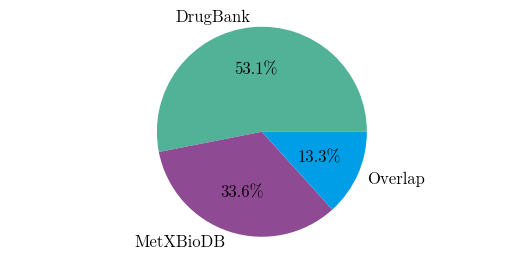

In [2]:
def source_analysis(csv_file, save_figure=None):
    plt.figure(figsize=(6.5, 3))
    plt.rcParams.update(
        {"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]}
    )

    df = pd.read_csv(csv_file)

    counts = df["source"].value_counts()

    labels = ["DrugBank", "MetXBioDB", "Overlap"]

    colors = ["#52B297", "#8E4A93", "#009EE7", "#EF766E"]

    plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=colors)  # startangle=90)
    plt.axis("equal")

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


after = "../dataset/curated_data/combined_smiles_clean.csv"
source_analysis(after, "piechart")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


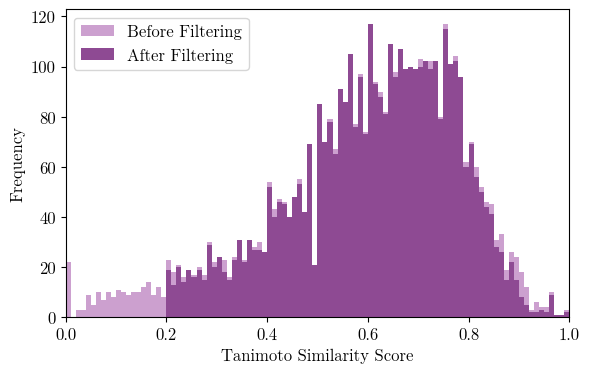

In [3]:
def fingerprint_similarity(csv_file):
    df = pd.read_csv(csv_file)
    parent_smiles = df["parent_smiles"].tolist()
    metabolite_smiles = df["child_smiles"].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    parent_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in parent_mol
    ]
    metabolite_fps = [
        AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024)
        for x in metabolite_mol
    ]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        s = DataStructs.TanimotoSimilarity(parent_fps[i], metabolite_fps[i])
        fingerprint_similarities.append(s)

    return fingerprint_similarities


def plot_fingerprint_similarity(csv_file_before, csv_file_after, save_figure=None):
    plt.figure(figsize=(6.5, 4))
    plt.rcParams.update(
        {"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]}
    )

    similarity_before = fingerprint_similarity(csv_file_before)
    similarity_after = fingerprint_similarity(csv_file_after)

    x_range = (0, 1)
    bin_width = 0.01
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    plt.hist(similarity_before, bins=bins, color="#CCA0CF", label="Before Filtering")
    plt.hist(similarity_after, bins=bins, color="#8E4A93", label="After Filtering")
    plt.xlabel("Tanimoto Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    # plt.ylim(0, 120)
    plt.xlim(0, 1)

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


before = "../dataset/curated_data/combined_smiles_before_filters.csv"
after = "../dataset/curated_data/combined_smiles_clean.csv"
plot_fingerprint_similarity(before, after, "fingerprints")

Max parent weights:  [4111.115376892007, 4111.115376892007, 1354.5674001259997, 1322.6672601919997, 1261.8624973600001]
Max child weights:  [2700.510203880001, 1343.5878012219996, 1294.6359600639996, 1277.8574119799998, 1277.8574119799998]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


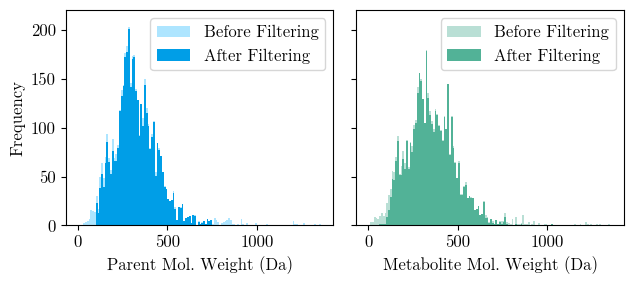

In [4]:
def molecular_weight_analysis_2(dataset):
    metabolite_weights, parent_weights = [], []

    parents = dataset["parent_smiles"]
    metabolites = dataset["child_smiles"]

    for parent, metabolite in zip(parents, metabolites):
        metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        metabolite_weights.append(metabolite_weight)

        parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        parent_weights.append(parent_weight)

    return metabolite_weights, parent_weights


def plot_molecular_weights_comparison(before_file, after_file, save_figure=None):
    df_before = pd.read_csv(before_file)
    df_after = pd.read_csv(after_file)

    metabolite_weights_before, parent_weights_before = molecular_weight_analysis_2(
        df_before
    )
    metabolite_weights_after, parent_weights_after = molecular_weight_analysis_2(
        df_after
    )

    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3), sharey=True)
    plt.rcParams.update(
        {"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]}
    )

    top_five_maximums = sorted(parent_weights_before, reverse=True)[:5]
    print("Max parent weights: ", top_five_maximums)

    top_five_maximums = sorted(metabolite_weights_before, reverse=True)[:5]
    print("Max child weights: ", top_five_maximums)

    x_range = (0, 1360)
    bin_width = 10
    bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)

    axes[0].hist(
        parent_weights_before, bins=bins, color="#ADE5FF", label="Before Filtering"
    )
    axes[0].hist(
        parent_weights_after, bins=bins, color="#009EE7", label="After Filtering"
    )
    axes[0].set_xlabel("Parent Mol. Weight (Da)")
    axes[0].set_ylabel("Frequency")
    # axes[0].set_xlim(0, 800)
    axes[0].legend()

    axes[1].hist(
        metabolite_weights_before, bins=bins, color="#B9DFD5", label="Before Filtering"
    )
    axes[1].hist(
        metabolite_weights_after, bins=bins, color="#52B297", label="After Filtering"
    )
    axes[1].set_xlabel("Metabolite Mol. Weight (Da)")
    # axes[1].set_xlim(0, 800)
    axes[1].set_ylim(0, 220)
    axes[1].legend()

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps", bbox_inches='tight')

    plt.tight_layout()
    plt.show()


before = "../dataset/curated_data/combined_smiles_before_filters.csv"
after = "../dataset/curated_data/combined_smiles_clean.csv"
plot_molecular_weights_comparison(before, after, "weight_comparison")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


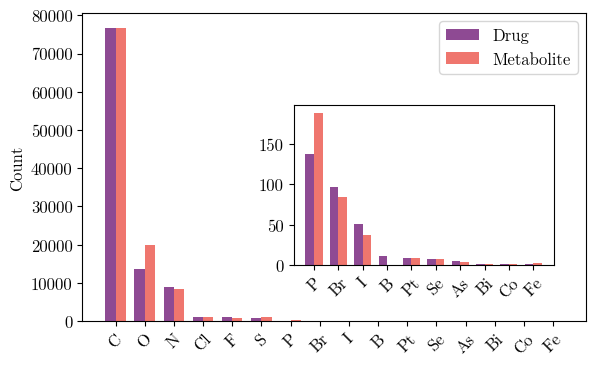

In [5]:
# Element count
def define_atoms(molecule):
    mol = Chem.MolFromSmiles(molecule)
    atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_counts = Counter(atoms)
    return atom_counts


def analyse_atoms(data, column):
    total_atoms_count = Counter()

    for molecule in data[column]:
        atom_counts = define_atoms(molecule)
        total_atoms_count.update(atom_counts)

    return total_atoms_count


def print_atom_counts(atom_counts):
    for atom, count in atom_counts.items():
        print(f"{atom}: {count}")


def plot_histogram(parent_atom_counts, child_atom_counts, save_figure=None):

    all_atoms = set(list(parent_atom_counts.keys()) + list(child_atom_counts.keys()))

    atom_data = [(atom, parent_atom_counts.get(atom, 0), child_atom_counts.get(atom, 0)) for atom in all_atoms]
    sorted_atoms = sorted(atom_data, key=lambda x: x[1], reverse=True)

    full_order, parent_counts, child_counts = zip(*sorted_atoms)
    full_order = list(full_order)

    remaining_atoms = full_order[6:]

    plt.figure(figsize=(6.5, 4))
    plt.rcParams.update(
        {"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]}
    )
    bar_width = 0.35
    index = range(len(full_order))

    plt.bar(index, parent_counts, bar_width, label="Drug", color="#8E4A93")
    plt.bar(
        [i + bar_width for i in index],
        child_counts,
        bar_width,
        label="Metabolite",
        color="#EF766E",
    )

    plt.ylabel("Count")
    plt.xticks([i + bar_width / 2 for i in index], full_order, rotation=45)
    plt.legend()

    if remaining_atoms:
        inset_ax = plt.axes([0.45, 0.25, 0.4, 0.4])  # [left, bottom, width, height]
        inset_index = range(len(remaining_atoms))
        inset_parent_counts = [
            parent_atom_counts.get(atom, 0) for atom in remaining_atoms
        ]
        inset_child_counts = [
            child_atom_counts.get(atom, 0) for atom in remaining_atoms
        ]

        inset_ax.bar(
            inset_index, inset_parent_counts, bar_width, color="#8E4A93", label="Drug"
        )
        inset_ax.bar(
            [i + bar_width for i in inset_index],
            inset_child_counts,
            bar_width,
            color="#EF766E",
            label="Metabolite",
        )

        inset_ax.set_xticks([i + bar_width / 2 for i in inset_index])
        inset_ax.set_xticklabels(remaining_atoms, rotation=45)
        # inset_ax.set_title('Remaining Atoms')

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()


after = "../dataset/curated_data/combined_smiles_before_filters.csv"
data = pd.read_csv(after)

parent_atom_counts = analyse_atoms(data, "parent_smiles")
child_atom_counts = analyse_atoms(data, "child_smiles")

plot_histogram(parent_atom_counts, child_atom_counts, "element_count")


Number of children summary:
1324 parents with 1 child(ren)
494 parents with 2 child(ren)
228 parents with 3 child(ren)
95 parents with 4 child(ren)
46 parents with 5 child(ren)
26 parents with 6 child(ren)
17 parents with 7 child(ren)
9 parents with 8 child(ren)
3 parents with 9 child(ren)
1 parents with 10 child(ren)
3 parents with 11 child(ren)
1 parents with 13 child(ren)
1 parents with 19 child(ren)
total parents: 2248


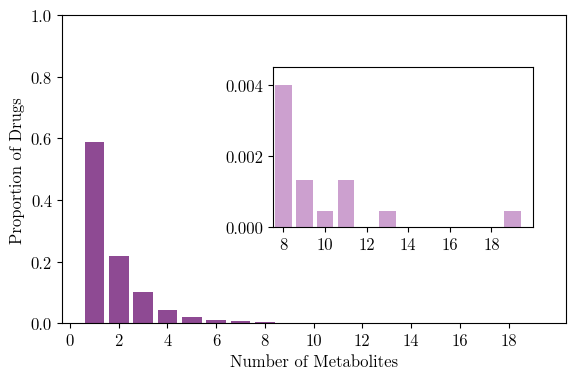

In [6]:
def number_of_children_zoom(csv, save_figure=None):
    df = pd.read_csv(csv)
    child_counts = df["parent_smiles"].value_counts()
    occurrence_summary = child_counts.value_counts().sort_index()

    number_of_children_list = []
    frequency_list = []

    print("Number of children summary:")
    for number_of_children, frequency in occurrence_summary.items():
        print(f"{frequency} parents with {number_of_children} child(ren)")

        number_of_children_list.append(number_of_children)
        frequency_list.append(frequency)

    total_parents = sum(frequency_list)
    print(f"total parents: {total_parents}")
    normalized_frequencies = [freq / total_parents for freq in frequency_list]

    plt.figure(figsize=(6.5, 4))
    plt.rcParams.update(
        {"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]}
    )

    plt.bar(number_of_children_list, normalized_frequencies, color="#8E4A93")
    plt.xlabel("Number of Metabolites")
    plt.ylabel("Proportion of Drugs")
    plt.ylim(0, 1)
    plt.xticks(range(0, max(number_of_children_list) + 1, 2))

    inset_ax = plt.axes([0.45, 0.35, 0.4, 0.4])  # [left, bottom, width, height]
    inset_ax.bar(
        [x for x in number_of_children_list if x > 7],
        [f for x, f in zip(number_of_children_list, normalized_frequencies) if x > 7],
        color="#CCA0CF",
    )
    inset_ax.set_xlim(7.5, 20)
    inset_ax.set_ylim(0, 0.0045)
    plt.xticks(range(8, 20, 2))

    if save_figure is not None:
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/{save_figure}.eps", format="eps")

    plt.show()

def number_of_parents(csv):
    df = pd.read_csv(csv)
    child_counts = df["child_smiles"].value_counts()
    occurrence_summary = child_counts.value_counts().sort_index()

    number_of_children_list = []
    frequency_list = []

    print("Number of children summary:")
    for number_of_children, frequency in occurrence_summary.items():
        print(f"{frequency} children with {number_of_children} parent(s)")

        number_of_children_list.append(number_of_children)
        frequency_list.append(frequency)


after = "../dataset/curated_data/combined_smiles_clean.csv"
# number_of_parents(after)
# print('\t')
number_of_children_zoom(after, "nr_of_children")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


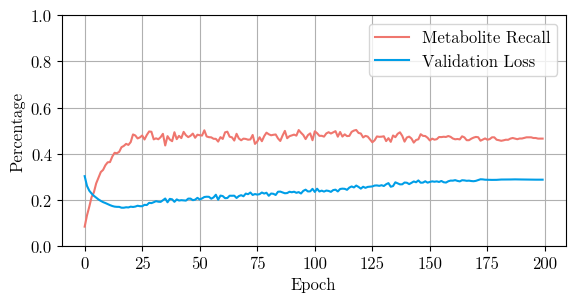

In [7]:
def plot_metrics_report(csv_file_path, save_figure):
    data = pd.read_csv(csv_file_path, sep='\t')

    colour_scheme = ['#52B297', '#8E4A93', '#009EE7', '#EF766E']

    epoch = data['epoch']
    metabolite_coverage_score = data['metabolite_coverage_score']
    validation_loss = data['validation_loss']

    plt.figure(figsize=(6.5, 3))
    plt.rcParams.update({"font.size": 12, "font.family": "serif", "font.serif": ["NewComputerModern10"]})
    
    plt.plot(epoch, metabolite_coverage_score, label='Metabolite Recall', color=colour_scheme[3])
    plt.plot(epoch, validation_loss, label='Validation Loss', color=colour_scheme[2])
    
    plt.xlabel('Epoch')
    plt.ylabel('Percentage')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    # plt.xlim(0,30)

    if save_figure is not None:
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/{save_figure}.eps', format='eps', bbox_inches='tight')

    plt.show()


file = '../train_metrics/base_rand_logged_train_metrics.csv'
plot_metrics_report(file, 'metrics_base_rand') #epoch 52